In [1]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
wrk = op.Workspace()
wrk.settings['loglevel'] = 50
wrk.clear()
wrk.load_project('../fixtures/hysteresis_paper_project')
print(wrk)

C:\Users\Tom\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
OpenPNM Version 2.0.1-64800c Workspace
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 hysteresis_paper
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 Object Name     Object ID                                                        
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 network         <openpnm.network.GenericNetwork object at 0x1d4c2619db0>         
 geometry        <openpnm.geometry.GenericGeometry object at 0x1d4c7e54410>       
 air             <openpnm.phases.Air object at 0x1d4c7e54620>                     
 water           <openpnm.phases.Water object at 0x1d4c7e54d00>                   
 phys_air        <openpnm.physics.Standard object at 0x1d4c8290410>               
 phys_water      <openpnm.physics.Standard object at 0x1d4c8290f10>               
 injection       <openpnm.algorithms.MixedInva

In [2]:
prj = wrk['hysteresis_paper']
pn = prj.network
geom = prj.geometries('geometry')
air = prj.phases('air')
water = prj.phases('water')
phys_air = prj.physics('phys_air')
phys_water = prj.physics('phys_water')
IP_injection = prj.algorithms('injection')
IP_withdrawal = prj.algorithms('withdrawal')

In [3]:
def diffusivity(phase, conductance_model, axis=0):
    fd = op.algorithms.FickianDiffusion(network=pn)
    fd.setup(phase=phase, conductance=conductance_model)
    if axis == 0:
        fd.set_value_BC(pores=pn.pores('front_boundary'), values=1.0)
        fd.set_value_BC(pores=pn.pores('back_boundary'), values=0.5)
    elif axis == 1:
        fd.set_value_BC(pores=pn.pores('left_boundary'), values=1.0)
        fd.set_value_BC(pores=pn.pores('right_boundary'), values=0.5)
    else:
        fd.set_value_BC(pores=pn.pores('top_boundary'), values=1.0)
        fd.set_value_BC(pores=pn.pores('bottom_boundary'), values=0.5)
    fd.run()
    return fd.calc_effective_diffusivity()[0]

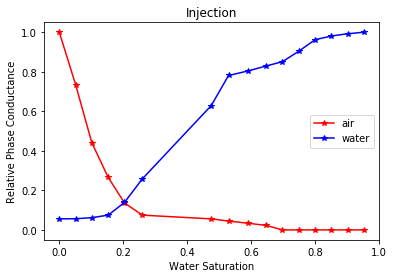

In [4]:
inv_points = np.arange(0, 15025, 25)
injection_data = IP_injection.get_intrusion_data(inv_points=inv_points)
args = [0]
sats = [0]
for i in range(len(injection_data.S_tot)):
    if injection_data.S_tot[i] - sats[-1] > 0.05:
        args.append(i)
        sats.append(injection_data.S_tot[i])
air.remove_model(['pore.occupancy'])
air.remove_model(['throat.occupancy'])
water.remove_model(['pore.occupancy'])
water.remove_model(['throat.occupancy'])
conds_air = []
conds_water = []
prop = 'throat.conduit_diffusive_conductance'
for Pc in injection_data.Pcap[args]:
    res = IP_injection.results(Pc)
    phys_air['throat.occupancy'] = res['throat.occupancy'] == 0.0
    phys_air['pore.occupancy'] = res['pore.occupancy'] == 0.0
    phys_water['throat.occupancy'] = res['throat.occupancy'] > 0.0
    phys_water['pore.occupancy'] = res['pore.occupancy'] > 0.0
    phys_air.regenerate_models(propnames=[prop])
    phys_water.regenerate_models(propnames=[prop])
    conds_air.append(diffusivity(air, prop))
    conds_water.append(diffusivity(water, prop))

conds_air = np.asarray(conds_air)/conds_air[0]
conds_water = np.asarray(conds_water)/conds_water[-1]
plt.figure()
plots = []
plots.append(plt.plot(sats, conds_air, 'r*-', label='air'))
plots.append(plt.plot(sats, conds_water, 'b*-', label='water'))
plt.xlabel('Water Saturation')
plt.ylabel('Relative Phase Conductance')
plt.title('Injection')
ax = plt.gca()
ax.legend()
isats = np.asarray(sats)
iconds_air = conds_air

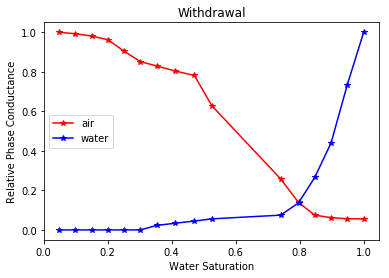

In [5]:
inv_points = np.arange(0, 15025, 25)
withdrawal_data = IP_withdrawal.get_intrusion_data(inv_points=inv_points)
args = [0]
sats = [0]
for i in range(len(withdrawal_data.S_tot)):
    if injection_data.S_tot[i] - sats[-1] > 0.05:
        args.append(i)
        sats.append(injection_data.S_tot[i])
sats = np.asarray(sats)
air.remove_model(['pore.occupancy'])
air.remove_model(['throat.occupancy'])
water.remove_model(['pore.occupancy'])
water.remove_model(['throat.occupancy'])
conds_air = []
conds_water = []
prop = 'throat.conduit_diffusive_conductance'
for Pc in injection_data.Pcap[args]:
    res = IP_injection.results(Pc)
    phys_air['throat.occupancy'] = res['throat.occupancy'] > 0.0
    phys_air['pore.occupancy'] = res['pore.occupancy'] > 0.0
    phys_water['throat.occupancy'] = res['throat.occupancy'] == 0.0
    phys_water['pore.occupancy'] = res['pore.occupancy'] == 0.0
    phys_air.regenerate_models(propnames=[prop])
    phys_water.regenerate_models(propnames=[prop])
    conds_air.append(diffusivity(air, prop))
    conds_water.append(diffusivity(water, prop))

conds_air = np.asarray(conds_air)/conds_air[-1]
conds_water = np.asarray(conds_water)/conds_water[0]
plt.figure()
plots = []
plots.append(plt.plot(1-sats, conds_air, 'r*-', label='air'))
plots.append(plt.plot(1-sats, conds_water, 'b*-', label='water'))
plt.xlabel('Water Saturation')
plt.ylabel('Relative Phase Conductance')
plt.title('Withdrawal')
ax = plt.gca()
ax.legend()
wsats = sats
wconds_air = conds_air

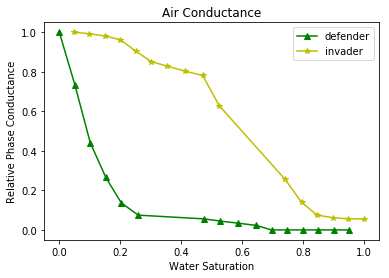

In [6]:
plt.figure()
plots = []
plots.append(plt.plot(isats, iconds_air, 'g^-', label='defender'))
plots.append(plt.plot(1-wsats, wconds_air, 'y*-', label='invader'))
plt.xlabel('Water Saturation')
plt.ylabel('Relative Phase Conductance')
plt.title('Air Conductance')
ax = plt.gca()
ax.legend()